# **Methodology**

## **Data**

The database used in this study originates from (https://www.science.org/doi/10.1126/science.aav0379.)



In [ ]:
#@title Download Data
!wget -O aav0379__scheele_data_s1.xlsx \
  https://raw.githubusercontent.com/bguzmanm-rgb/ecological_simililarity_networks/main/aav0379__scheele_data_s1.xlsx

--2025-12-27 06:30:41--  https://raw.githubusercontent.com/bguzmanm-rgb/ecological_simililarity_networks/main/aav0379__scheele_data_s1.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5910942 (5.6M) [application/octet-stream]
Saving to: ‘aav0379__scheele_data_s1.xlsx’

aav0379__scheele_da 100%[===================>]   5.64M  14.1MB/s    in 0.4s    

2025-12-27 06:30:42 (14.1 MB/s) - ‘aav0379__scheele_data_s1.xlsx’ saved [5910942/5910942]



In [ ]:
#@title Load the libraries and Data

# Load the libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.random_graphs import erdos_renyi_graph
from typing import Dict, List
from math import sqrt

# Load the data
anfibios = pd.read_excel("aav0379__scheele_data_s1.xlsx", sheet_name = "Declined_species")
anfibios.head()

,Species,Order,Family,Genus,Taxonomic notes,Countries of decline,Continent,Severity,Evidence,Bd diagnosed,...,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19,AmphiBIO_id,Body_size_mm,Litter_size_max_n,References
0,Adelophryne baturitensis,Anura,Eleutherodactylidae,Adelophryne,NaN,Brazil,South America,3,2,No data,...,2.174,109.056,503.054,8.161,94.578,101.182,Anf1996,16.3,5.0,"48, 49"
1,Adelotus brevis,Anura,Limnodynastidae,Adelotus,Formerly Leptodactylidae,Australia,Oceania,1,3,No data,...,31.839,43.780,336.843,112.320,327.925,121.152,Anf3454,45.0,243.0,"51, 52, 53, 54"
2,Adenomera andreae,Anura,Leptodactylidae,Adenomera,NaN,Peru,South America,1,3,Yes,...,69.109,51.070,909.695,243.546,426.524,614.543,NaN,NaN,NaN,"25, 55"
3,Adenomera marmorata,Anura,Leptodactylidae,Adenomera,NaN,Brazil,South America,1,3,No data,...,36.436,62.015,672.119,128.577,617.946,132.252,NaN,NaN,NaN,"49, 56"
4,Afrixalus paradorsalis,Anura,Hyperoliidae,Afrixalus,NaN,Cameroon,Africa,1,3,Yes (retrospectively),...,24.508,61.659,797.224,114.776,475.475,417.624,Anf3075,35.0,NaN,57


In [ ]:
#@title Data Filtering and Cleaning
# Filter information based on the specified conditions
paises = ["Argentina", "Bolivia", "Chile", "Colombia", "Ecuador", "Peru", "Venezuela"]
# Filter rows that contain any of the countries included in the research
anfibios = anfibios[anfibios["Countries of decline"].str.contains("|".join(paises), case = False, na = False)]
# Filter altitudes higher than 1600 m.a.s.l.
anfibios['altitud_max'] = anfibios['Alt_range'].str.extract(r'-(\d+)', expand = False).astype(float)
anfibios = anfibios[anfibios['altitud_max'] > 1600]
# Filter the columns defined initially
anfibios = anfibios[["Species", "Order", "Severity", "Evidence", "Environment", "Aquatic", "Topography", "Latitude", "Longitude", "Countries of decline"]]
# Filter for Anurans only
anfibios = anfibios[anfibios["Order"] == "Anura"]
# Remove null values
anfibios = anfibios.dropna()
anfibios.reset_index(drop=True, inplace=True)
anfibios

,Species,Order,Severity,Evidence,Environment,Aquatic,Topography,Latitude,Longitude,Countries of decline
0,Alsodes tumultuosus,Anura,1,3,alpine,2,steep,-33.250000,-70.210000,Chile
1,Aromobates meridensis,Anura,3,2,tropical,2,undulating,8.630000,-71.420000,Venezuela
2,Atelopus andinus,Anura,2,2,sub-alpine-tropical,2,undulating,-8.110000,-75.880000,Peru
3,Atelopus angelito,Anura,4,3,alpine sub-alpine,2,steep,1.850000,-76.780000,Ecuador
4,Atelopus arthuri,Anura,4,3,sub-alpine,2,steep,-1.820000,-78.970000,Ecuador
...,...,...,...,...,...,...,...,...,...,...
103,Telmatobius truebae,Anura,3,3,alpine tropical,3,steep,-6.410000,-77.780000,Peru
104,Telmatobius vellardi,Anura,2,2,sub-alpine-tropical,3,undulating,-4.119722,-78.151667,Ecuador
105,Telmatobius verrucosus,Anura,4,3,sub-alpine temperate,3,"undulating, steep",-16.330000,-67.810000,Bolivia
106,Telmatobius yuracare,Anura,3,3,tropical,3,steep,-17.500000,-65.260000,Bolivia


In [ ]:
#@title Export Summary Table
columnas_reporte = ["Species", "Order", "Environment", "Topography", "Countries of decline"]
anfibios[columnas_reporte].to_excel("Tabla_Resumen_Especies.xlsx", index=False)

print("Excel file successfully generated! Find the file in your working folder.")

Excel file successfully generated! Find the file in your working folder.


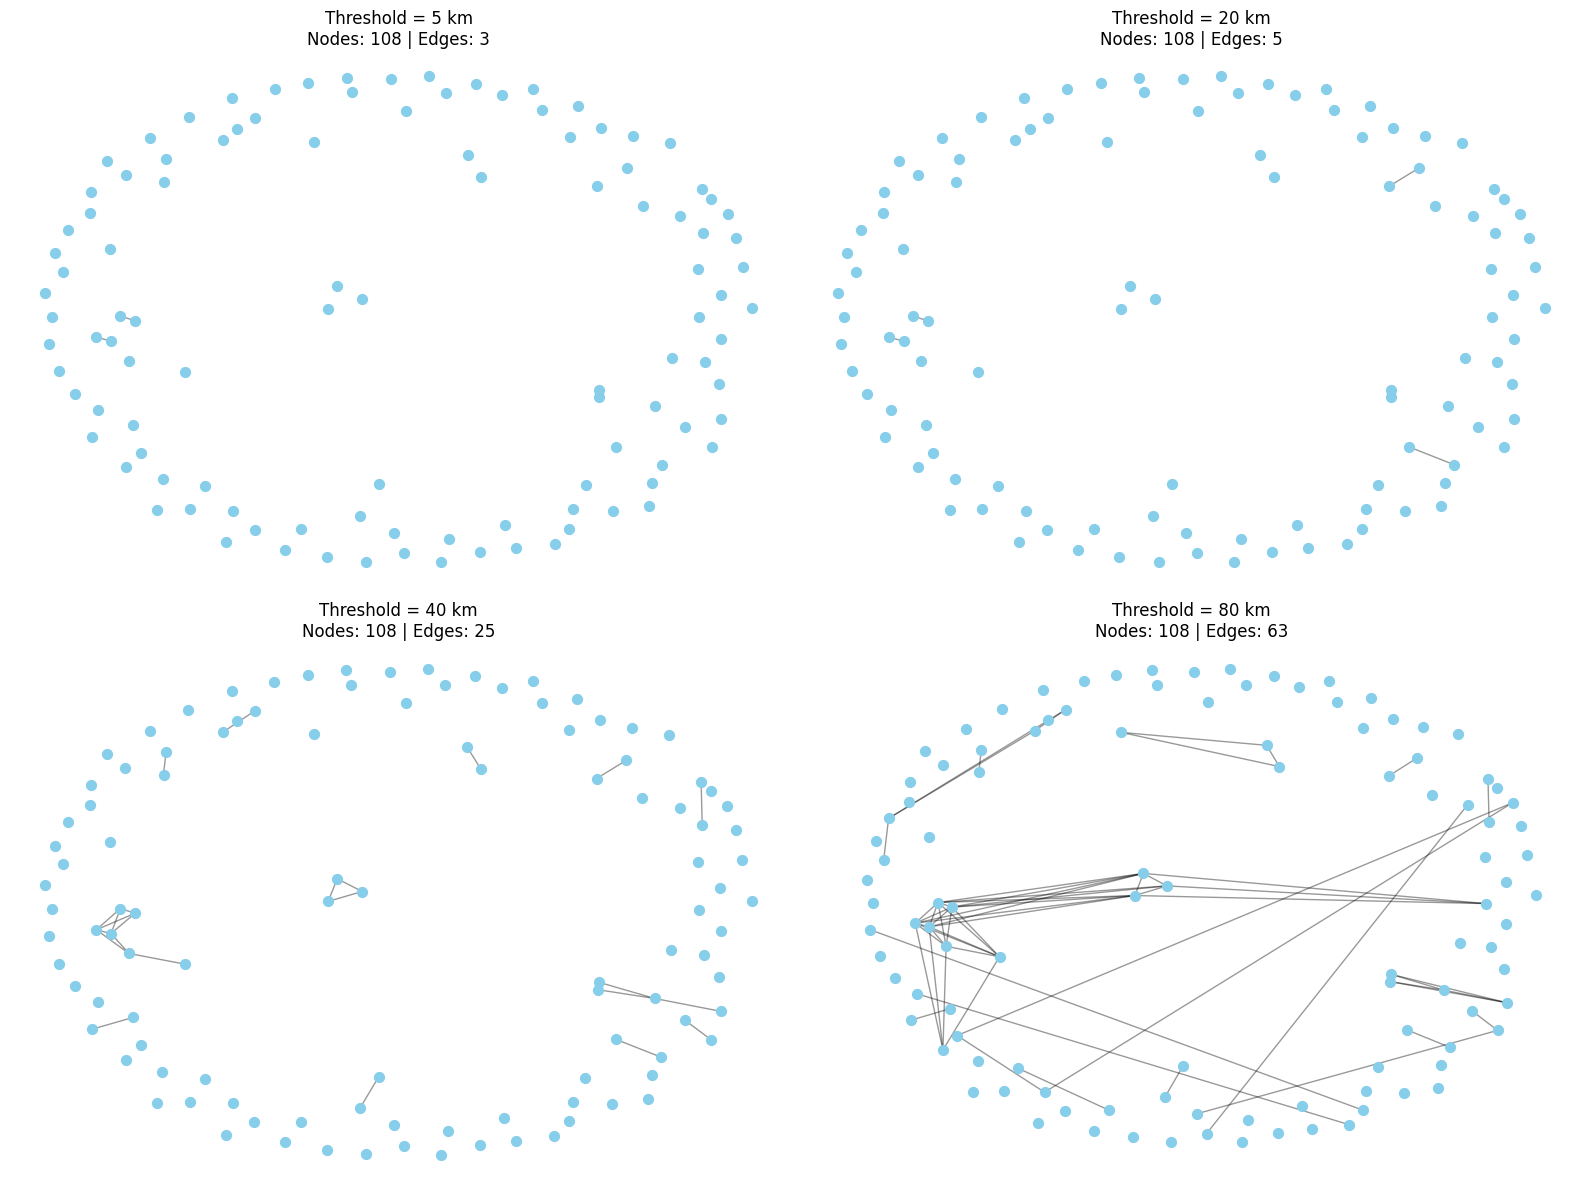

In [ ]:
#@title Network Construction and Sensitivity Analysis
import matplotlib.pyplot as plt
import networkx as nx
# Import the necessary trigonometric functions for Haversine
from math import radians, cos, sin, asin, sqrt

# ------- HELPER FUNCTION: HAVERSINE -------
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculates the great circle distance between two points
    on the earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Earth's radius in kilometers
    return c * r

# ------- FUNCTION TO BUILD NETWORK BASED ON THRESHOLD -------
def construir_red(anfibios, umbral_km):
    G = nx.Graph()

    # Add nodes
    for _, row in anfibios.iterrows():
        G.add_node(row['Species'], **row.to_dict())

    # Add edges
    # Iterate over all possible pairs
    for i, row1 in anfibios.iterrows():
        for j, row2 in anfibios.iterrows():
            if i >= j:
                continue

            # Ecological criteria
            mismo_ambiente = row1['Environment'].lower() == row2['Environment'].lower()
            misma_topografia = row1['Topography'].strip().lower() == row2['Topography'].strip().lower()

            # Coordinates
            lat1, lon1 = row1['Latitude'], row1['Longitude']
            lat2, lon2 = row2['Latitude'], row2['Longitude']

            # --- CORRECTION HERE: EXACT CALCULATION WITH HAVERSINE ---
            dist = haversine(lon1, lat1, lon2, lat2)

            # Evaluate conditions
            if mismo_ambiente and misma_topografia and dist <= umbral_km:
                # The weight is still inverse to the distance
                G.add_edge(row1['Species'], row2['Species'], weight=1/(dist + 0.01))

    return G

# ------- CREATE NETWORKS FOR SENSITIVITY ANALYSIS -------
umbrales = [5, 20, 40, 80]
redes = [construir_red(anfibios, u) for u in umbrales]

# Unique layout for comparison (based on the 40 km network for visual consistency)
pos = nx.spring_layout(redes[2], seed=12)

# ------- FIGURE -------
plt.figure(figsize=(16, 12))

for i, (u, Gx) in enumerate(zip(umbrales, redes)):
    plt.subplot(2, 2, i+1)
    # Draw nodes and edges
    nx.draw_networkx_nodes(Gx, pos, node_size=50, node_color='skyblue')
    nx.draw_networkx_edges(Gx, pos, alpha=0.4)

    # Informative title
    plt.title(f"Threshold = {u} km\nNodes: {Gx.number_of_nodes()} | Edges: {Gx.number_of_edges()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#@title Network Components Selection
def select_gigantic_component(g: nx.Graph, n: int) -> nx.Graph:
    comps = sorted(nx.connected_components(g), key=len, reverse=True)
    return g.subgraph(comps[n]).copy()

G = construir_red(anfibios, 40)  # Example with 40 km
g0 = select_gigantic_component(G, 0)
g1 = select_gigantic_component(G, 1)

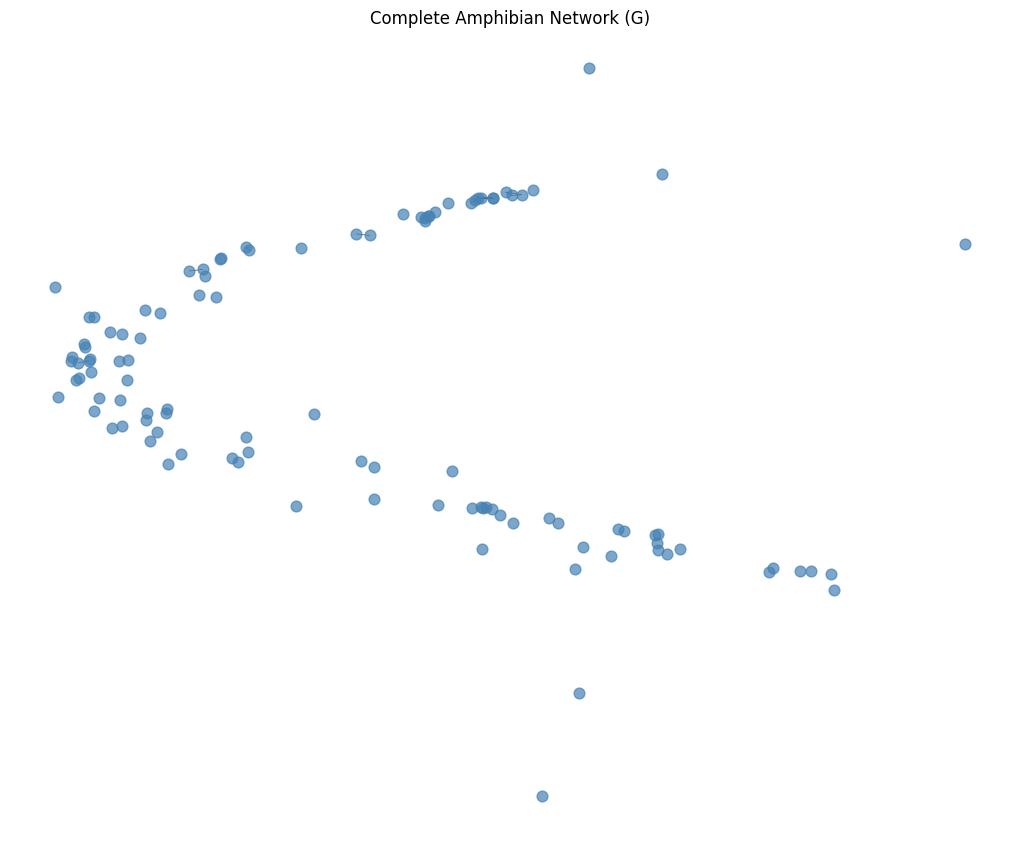

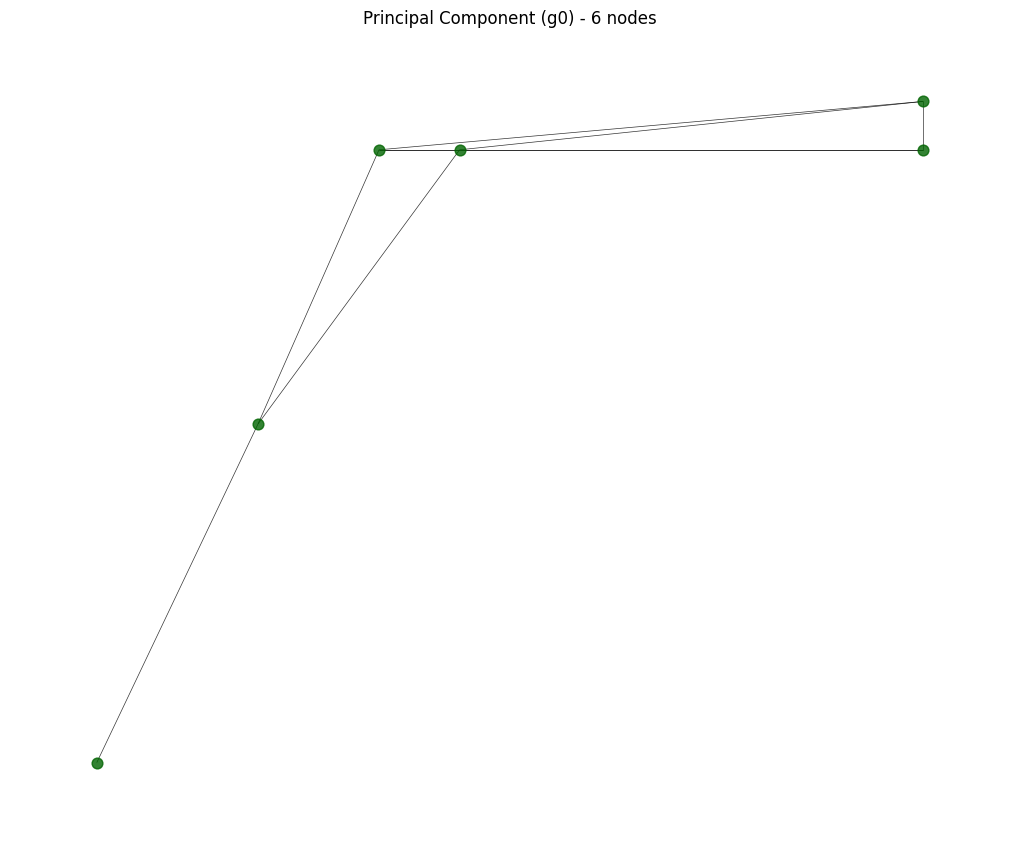

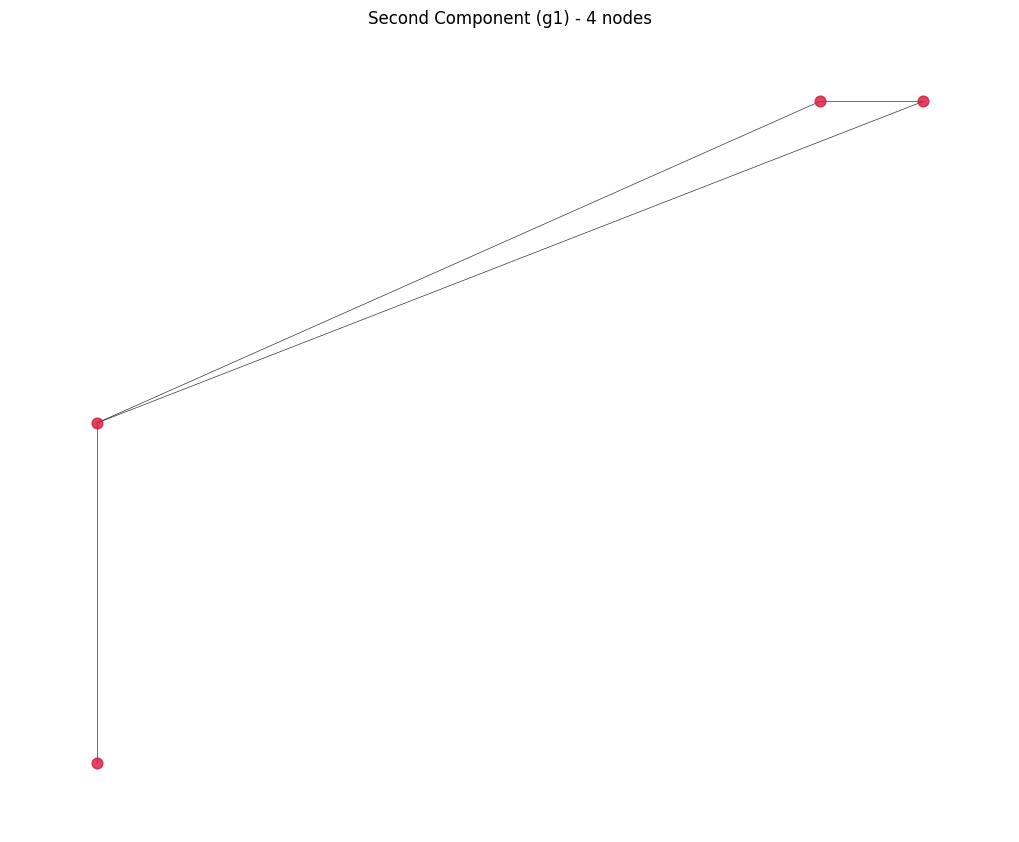

In [ ]:
#@title Network Visualization of Components
import networkx as nx
import matplotlib.pyplot as plt

# 1. DEFINE THE MISSING FUNCTION
def anfibian_layout(df):
    """
    Creates a dictionary of positions using Longitude (x) and Latitude (y)
    to make the graph look like a map.
    """
    pos = {}
    # Assuming your 'anfibios' dataframe has 'Species', 'Longitude', 'Latitude' columns
    for _, row in df.iterrows():
        pos[row['Species']] = (row['Longitude'], row['Latitude'])
    return pos

# 2. ENSURE NETWORKS (G, g0, g1) ARE AVAILABLE
# Using the 40km threshold chosen as optimal
G = construir_red(anfibios, 40)

# Get connected components sorted by size (largest to smallest)
componentes = sorted(nx.connected_components(G), key=len, reverse=True)

# g0 is the giant component (the largest one)
g0 = G.subgraph(componentes[0]).copy()

# g1 is the second largest component (if it exists)
if len(componentes) > 1:
    g1 = G.subgraph(componentes[1]).copy()
else:
    g1 = nx.Graph() # Empty graph if no second component


# Generate positions
pos = anfibian_layout(anfibios)

# --- 1. FIGURE: COMPLETE NETWORK (G) ---
plt.figure(figsize=(10, 8))
# Draw only if there are nodes
if G.number_of_nodes() > 0:
    nx.draw(G, pos, width=0.5, node_size=60, node_color='steelblue', alpha=0.7)
plt.title("Complete Amphibian Network (G)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# --- 2. FIGURE: GIANT COMPONENT (g0) ---
plt.figure(figsize=(10, 8))
if g0.number_of_nodes() > 0:
    nx.draw(g0, pos, width=0.5, node_size=60, node_color='darkgreen', alpha=0.8)
plt.title(f"Principal Component (g0) - {g0.number_of_nodes()} nodes")
plt.show()

# --- 3. FIGURE: SECOND COMPONENT (g1) ---
plt.figure(figsize=(10, 8))
if g1.number_of_nodes() > 0:
    nx.draw(g1, pos, width=0.5, node_size=60, node_color='crimson', alpha=0.8)
    plt.title(f"Second Component (g1) - {g1.number_of_nodes()} nodes")
else:
    plt.title("No significant second component exists")
plt.show()

In [ ]:
#@title Summary of Network Metrics
import pandas as pd

# 1. Create a summary table with network metrics
resumen_dict = {
    "Network": ["Complete (G)", "Giant Component (g0)", "Secondary Component (g1)"],
    "No. Species (Nodes)": [G.number_of_nodes(), g0.number_of_nodes(), g1.number_of_nodes()],
    "No. Interactions (Edges)": [G.number_of_edges(), g0.number_of_edges(), g1.number_of_edges()]
}

df_resumen = pd.DataFrame(resumen_dict)

# 2. Get the lists of species names
# Convert them into DataFrames to display as tables
especies_g0 = pd.DataFrame(sorted(list(g0.nodes())), columns=["Species in g0"])
especies_g1 = pd.DataFrame(sorted(list(g1.nodes())), columns=["Species in g1"])

# --- DISPLAY RESULTS ---
print("--- NETWORK SUMMARY ---")
print(df_resumen.to_string(index=False))

print("\n--- LIST OF SPECIES IN g0 (Top 10) ---")
print(especies_g0.head(10))

print("\n--- LIST OF SPECIES IN g1 ---")
print(especies_g1)

--- NETWORK SUMMARY ---
                 Network  No. Species (Nodes)  No. Interactions (Edges)
            Complete (G)                  108                        25
    Giant Component (g0)                    6                         9
Secondary Component (g1)                    4                         4

--- LIST OF SPECIES IN g0 (Top 10) ---
              Species in g0
0     Aromobates meridensis
1    Atelopus carbonerensis
2      Atelopus oxyrhynchus
3         Atelopus sorianoi
4  Dendropsophus meridensis
5      Mannophryne collaris

--- LIST OF SPECIES IN g1 ---
           Species in g1
0      Atelopus tamaense
1  Dendropsophus pelidna
2    Gastrotheca helenae
3  Pristimantis nicefori


In [ ]:
#@title Network Metrics and Null Models
import pandas as pd
import networkx as nx
import numpy as np

def calcular_metricas(g, label):
    if g.number_of_nodes() == 0:
        return None

    # Basic Metrics
    n = g.number_of_nodes()
    m = g.number_of_edges()
    density = nx.density(g)

    # Clustering and Paths (Shortest Path only if connected)
    avg_clustering = nx.average_clustering(g)
    try:
        avg_path_length = nx.average_shortest_path_length(g)
    except nx.NetworkXError:
        # If not connected (like total G), it is usually calculated on the giant component
        avg_path_length = np.nan

    # Average Centralities
    deg_cent = np.mean(list(nx.degree_centrality(g).values()))
    bet_cent = np.mean(list(nx.betweenness_centrality(g).values()))
    clo_cent = np.mean(list(nx.closeness_centrality(g).values()))

    return {
        "Network": label,
        "Nodes (N)": n,
        "Edges (E)": m,
        "Density": f"{density:.4f}",
        "Avg Clustering": f"{avg_clustering:.4f}",
        "Avg Path Length": f"{avg_path_length:.4f}",
        "Mean Degree Cent.": f"{deg_cent:.4f}",
        "Mean Betw. Cent.": f"{bet_cent:.4f}",
        "Mean Clos. Cent.": f"{clo_cent:.4f}"
    }

# --- Generation of Null Models ---
def generar_modelos_nulos(g_ref):
    n = g_ref.number_of_nodes()
    m = g_ref.number_of_edges()
    p = nx.density(g_ref)
    k_ws = max(2, int(2 * m / n)) # k for Watts-Strogatz (must be an integer)

    # Erdős-Rényi (Preserving N and M)
    er = nx.gnm_random_graph(n, m)

    # Watts-Strogatz (Small-world, p=0.1 rewiring probability)
    ws = nx.watts_strogatz_graph(n, k_ws, p=0.1)

    return er, ws

# --- Execution ---
metricas_lista = []

# Calculate for real networks
for grafo, nombre in zip([G, g0, g1], ["Empirical G", "Empirical g0", "Empirical g1"]):
    metricas_lista.append(calcular_metricas(grafo, nombre))

    # Generate and calculate for their null models (based on g0 as the core)
    if nombre == "Empirical g0":
        er_g0, ws_g0 = generar_modelos_nulos(g0)
        metricas_lista.append(calcular_metricas(er_g0, "Null ER (g0)"))
        metricas_lista.append(calcular_metricas(ws_g0, "Null WS (g0)"))

df_resultados = pd.DataFrame(metricas_lista)
print(df_resultados.to_string(index=False))

     Network  Nodes (N)  Edges (E) Density Avg Clustering Avg Path Length Mean Degree Cent. Mean Betw. Cent. Mean Clos. Cent.
 Empirical G        108         25  0.0043         0.0833             nan            0.0043           0.0000           0.0046
Empirical g0          6          9  0.6000         0.6111          1.5333            0.6000           0.1333           0.6809
Null ER (g0)          6          9  0.6000         0.6778          1.4000            0.6000           0.1000           0.7404
Null WS (g0)          6          6  0.4000         0.0000          1.9333            0.4000           0.2333           0.5367
Empirical g1          4          4  0.6667         0.5833          1.3333            0.6667           0.1667           0.7750


In [ ]:
#@title Calculate Modularity
from networkx.algorithms import community

def calcular_modularidad(g):
    # We use the Louvain algorithm to detect communities
    communities = community.louvain_communities(g)
    return community.modularity(g, communities)

# We calculate for the real network and the models
mod_real = calcular_modularidad(g0)
er_g0, ws_g0 = generar_modelos_nulos(g0)
mod_er = calcular_modularidad(er_g0)
mod_ws = calcular_modularidad(ws_g0)

print(f"Empirical Modularity (g0): {mod_real:.4f}")
print(f"ER Model Modularity: {mod_er:.4f}")
print(f"WS Model Modularity: {mod_ws:.4f}")

Empirical Modularity (g0): 0.3162
ER Model Modularity: 0.1667
WS Model Modularity: 0.1667


In [ ]:
#@title Table of the most important species in g0 by Betweenness
top_centralidad = pd.DataFrame.from_dict(nx.betweenness_centrality(g0), orient='index', columns=['Betweenness'])
top_centralidad = top_centralidad.sort_values(by='Betweenness', ascending=False).head(10)
print("\n--- MOST INFLUENTIAL SPECIES (TOP 10 Betweenness) ---")
print(top_centralidad)


--- MOST INFLUENTIAL SPECIES (TOP 10 Betweenness) ---
                          Betweenness
Mannophryne collaris              0.4
Aromobates meridensis             0.2
Atelopus carbonerensis            0.2
Dendropsophus meridensis          0.0
Atelopus sorianoi                 0.0
Atelopus oxyrhynchus              0.0


In [ ]:
#@title Epidemiological Risk Analysis of Species (g0)
import pandas as pd
import networkx as nx

# 1. Calculate centrality metrics for the giant component g0
degree_cent = nx.degree_centrality(g0)
betweenness_cent = nx.betweenness_centrality(g0)
closeness_cent = nx.closeness_centrality(g0)

# 2. Create a DataFrame with the results
especies_criticas = pd.DataFrame({
    'Species': list(degree_cent.keys()),
    'Degree_Centrality': list(degree_cent.values()),
    'Betweenness_Centrality': list(betweenness_cent.values()),
    'Closeness_Centrality': list(closeness_cent.values())
})

# 3. Bring additional information from your original DataFrame (Anfibios) for context
# We want to see the "Severity" and "Countries of decline" of these species
info_extra = anfibios[['Species', 'Severity', 'Countries of decline', 'Environment']].drop_duplicates()
ranking_riesgo = especies_criticas.merge(info_extra, left_on='Species', right_on='Species')

# 4. Sort by Degree Centrality (most exposed/connected species)
ranking_riesgo = ranking_riesgo.sort_values(by='Degree_Centrality', ascending=False)

print("--- TOP SPECIES AT HIGHEST EPIDEMIOLOGICAL RISK (g0) ---")
print(ranking_riesgo[['Species', 'Degree_Centrality', 'Severity', 'Environment']].head(10))

# Save to Excel for your thesis
ranking_riesgo.to_excel("epidemiological_risk_analysis.xlsx", index=False)

--- TOP SPECIES AT HIGHEST EPIDEMIOLOGICAL RISK (g0) ---
                    Species  Degree_Centrality  Severity Environment
1     Aromobates meridensis                0.8         3    tropical
5    Atelopus carbonerensis                0.8         4    tropical
0  Dendropsophus meridensis                0.6         2    tropical
2      Atelopus oxyrhynchus                0.6         4    tropical
4      Mannophryne collaris                0.6         3    tropical
3         Atelopus sorianoi                0.2         4    tropical


In [ ]:
#@title Epidemiological Risk Analysis
import pandas as pd
import networkx as nx

def analizar_riesgo_epidemiologico(grafo, nombre_red, df_original):
    # 1. Calculate centrality metrics
    # Degree: Exposure and probability of contagion
    # Betweenness: Bridges between communities (critical for dispersion)
    # Closeness: Speed at which the Bd fungus would reach all nodes

    dict_degree = nx.degree_centrality(grafo)
    dict_betweenness = nx.betweenness_centrality(grafo)
    dict_closeness = nx.closeness_centrality(grafo)

    # 2. Create results DataFrame
    df_metrics = pd.DataFrame({
        'Species': list(dict_degree.keys()),
        'Degree_Centrality': list(dict_degree.values()),
        'Betweenness_Centrality': list(dict_betweenness.values()),
        'Closeness_Centrality': list(dict_closeness.values())
    })

    # 3. Merge with original metadata (Severity, Environment, etc.)
    metadata = df_original[['Species', 'Severity', 'Evidence', 'Environment', 'Topography', 'Countries of decline']].drop_duplicates()
    resultado = df_metrics.merge(metadata, left_on='Species', right_on='Species').drop(columns=['Species'])

    # 4. Sort by risk (Degree is the best indicator of initial exposure)
    return resultado.sort_values(by='Degree_Centrality', ascending=False)

# --- EXECUTION ---

# Analysis for the Complete Network (G)
riesgo_G = analizar_riesgo_epidemiologico(G, "Complete", anfibios)

# Analysis for the Giant Component (g0)
riesgo_g0 = analizar_riesgo_epidemiologico(g0, "g0", anfibios)

# Analysis for the Secondary Component (g1)
riesgo_g1 = analizar_riesgo_epidemiologico(g1, "g1", anfibios)

# --- SHOW TOP 5 OF EACH ---
print("--- TOP 5 EPIDEMIOLOGICAL RISK: COMPLETE NETWORK (G) ---")
display(riesgo_G.head(5))

print("\n--- TOP 5 EPIDEMIOLOGICAL RISK: COMPONENT g0 ---")
display(riesgo_g0.head(5))

print("\n--- TOP 5 EPIDEMIOLOGICAL RISK: COMPONENT g1 ---")
display(riesgo_g1.head(5))

# Export to Excel with different sheets
with pd.ExcelWriter('Epidemiological_Risk_Analysis.xlsx') as writer:
    riesgo_G.to_excel(writer, sheet_name='Complete_Network_G', index=False)
    riesgo_g0.to_excel(writer, sheet_name='Component_g0', index=False)
    riesgo_g1.to_excel(writer, sheet_name='Component_g1', index=False)

--- TOP 5 EPIDEMIOLOGICAL RISK: COMPLETE NETWORK (G) ---


,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality,Severity,Evidence,Environment,Topography,Countries of decline
1,0.037383,0.000353,0.038941,3,2,tropical,undulating,Venezuela
7,0.037383,0.000353,0.038941,4,2,tropical,undulating,Venezuela
43,0.028037,0.000353,0.028037,1,2,tropical,undulating,"Venezuela, Colombia"
25,0.028037,0.000000,0.029206,4,2,tropical,undulating,Venezuela
42,0.028037,0.000000,0.029206,2,2,tropical,undulating,Venezuela



--- TOP 5 EPIDEMIOLOGICAL RISK: COMPONENT g0 ---


,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality,Severity,Evidence,Environment,Topography,Countries of decline
1,0.8,0.2,0.833333,3,2,tropical,undulating,Venezuela
5,0.8,0.2,0.833333,4,2,tropical,undulating,Venezuela
0,0.6,0.0,0.625000,2,2,tropical,undulating,Venezuela
2,0.6,0.0,0.625000,4,2,tropical,undulating,Venezuela
4,0.6,0.4,0.714286,3,2,tropical,undulating,Venezuela



--- TOP 5 EPIDEMIOLOGICAL RISK: COMPONENT g1 ---


,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality,Severity,Evidence,Environment,Topography,Countries of decline
2,1.000000,0.666667,1.00,1,2,tropical,undulating,"Venezuela, Colombia"
1,0.666667,0.000000,0.75,4,2,tropical,undulating,Venezuela
3,0.666667,0.000000,0.75,2,2,tropical,undulating,Venezuela
0,0.333333,0.000000,0.60,1,3,tropical,undulating,Colombia


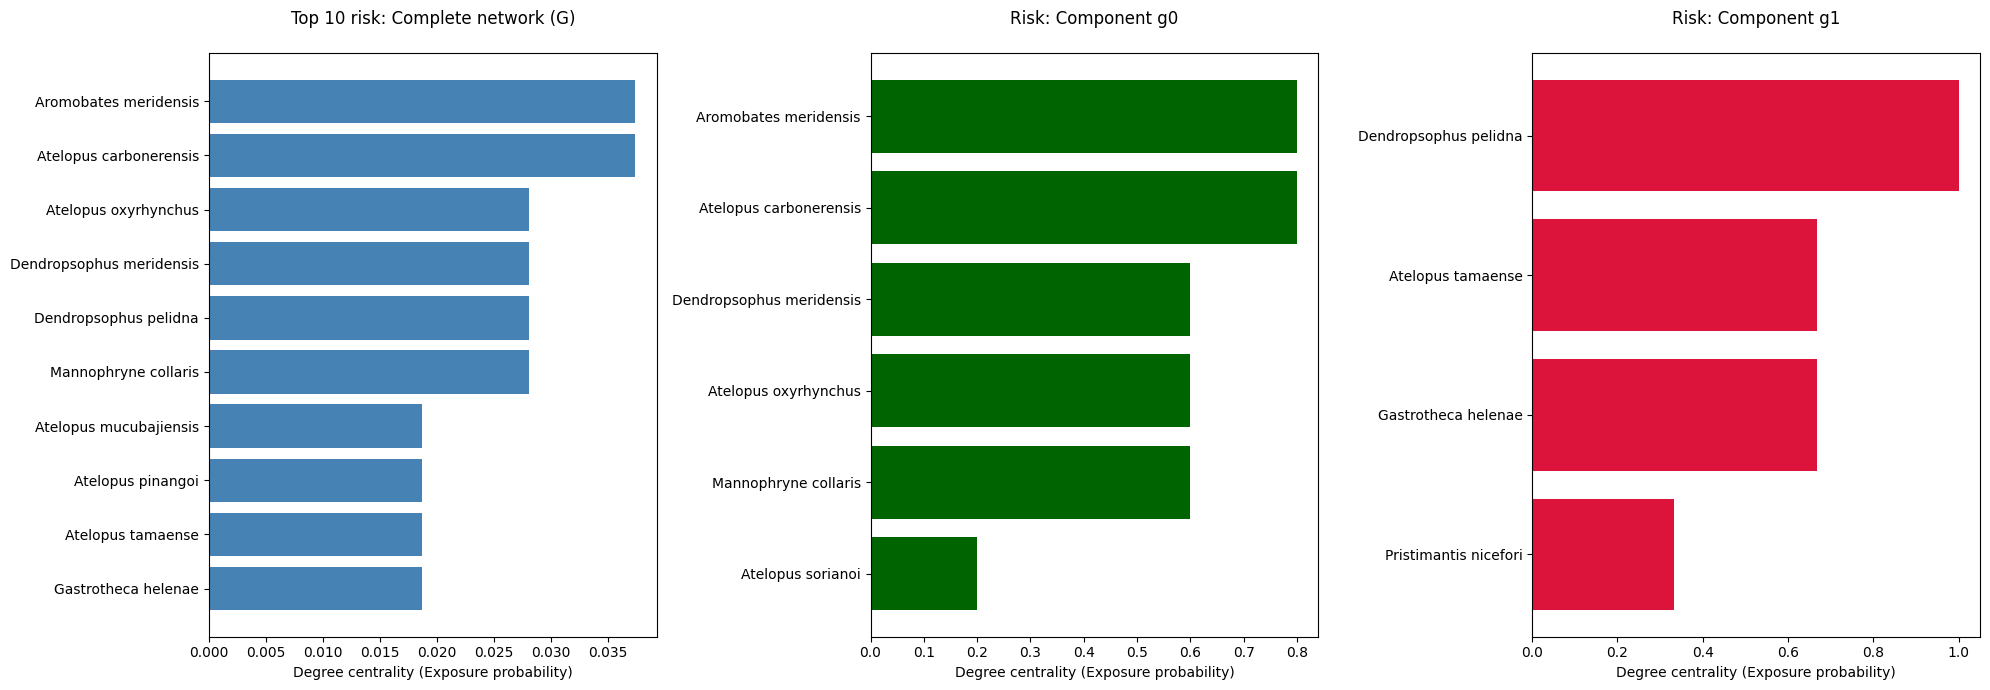

In [ ]:
#@title Top Species by Degree Centrality (Epidemiological Risk)
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def obtener_top_centralidad(grafo, n_top=10):
    cent = nx.degree_centrality(grafo)
    # Sort and take the top n_top
    sorted_cent = sorted(cent.items(), key=lambda x: x[1], reverse=True)[:n_top]
    return zip(*sorted_cent) # Returns species and values separately

# --- Figure Configuration ---
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=False)

# 1. Plot for Complete Network G (Global Risk)
especies_G, valores_G = obtener_top_centralidad(G)
axes[0].barh(especies_G, valores_G, color='steelblue')
axes[0].set_title("Top 10 risk: Complete network (G)\n")
axes[0].invert_yaxis()

# 2. Plot for g0 (Main Focus)
especies_g0, valores_g0 = obtener_top_centralidad(g0)
axes[1].barh(especies_g0, valores_g0, color='darkgreen')
axes[1].set_title("Risk: Component g0\n")
axes[1].invert_yaxis()

# 3. Plot for g1 (Secondary Focus)
especies_g1, valores_g1 = obtener_top_centralidad(g1)
axes[2].barh(especies_g1, valores_g1, color='crimson')
axes[2].set_title("Risk: Component g1\n")
axes[2].invert_yaxis()

# General labels
for ax in axes:
    ax.set_xlabel("Degree centrality (Exposure probability)")

plt.tight_layout()
plt.show()


--- DIRECTED ATTACK ON Component g0 ---
Node removed (Hub): Aromobates meridensis
Node centrality: 0.8000
Components before/after: 1 -> 1
Size of the new Giant Component: 5 species

--- DIRECTED ATTACK ON Component g1 ---
Node removed (Hub): Dendropsophus pelidna
Node centrality: 1.0000
Components before/after: 1 -> 2
Size of the new Giant Component: 2 species


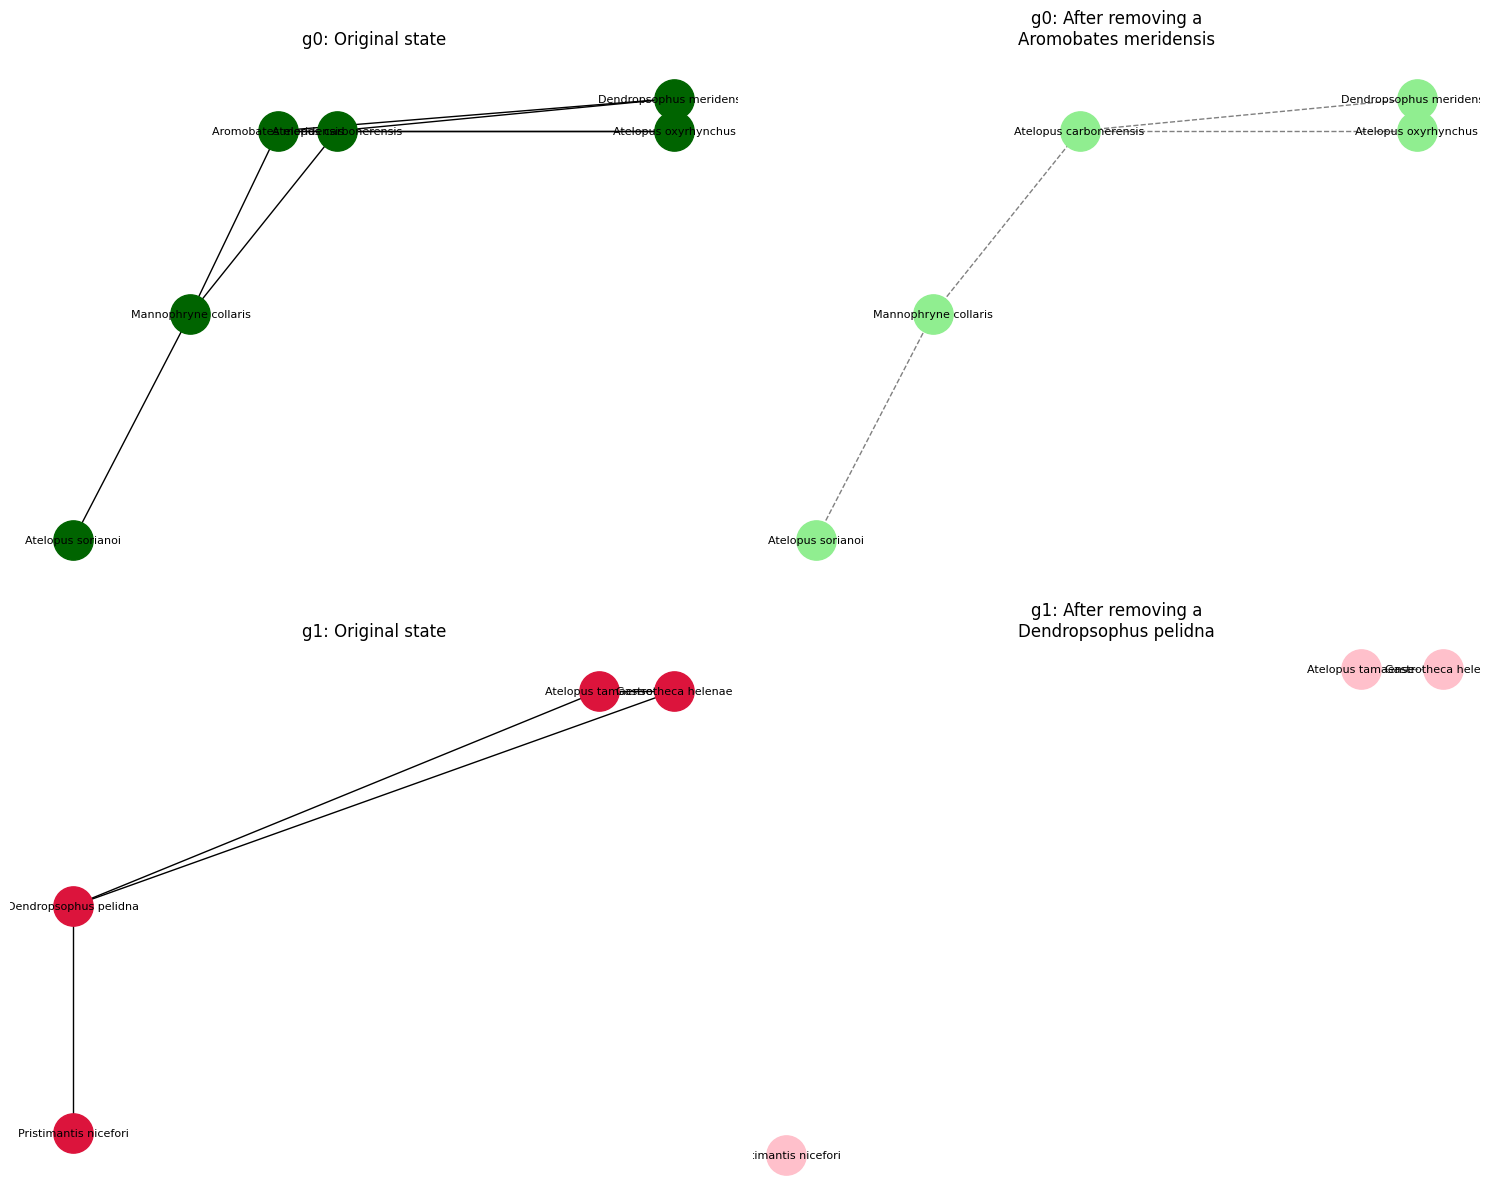

In [ ]:
#@title Directed Attack Simulation and Visualization
import matplotlib.pyplot as plt
import networkx as nx

def simular_ataque_dirigido(grafo, nombre_red):
    if grafo.number_of_nodes() == 0:
        return

    # 1. Identify the most central node (the "Target")
    centralidad = nx.degree_centrality(grafo)
    nodo_objetivo = max(centralidad, key=centralidad.get)
    valor_centralidad = centralidad[nodo_objetivo]

    # 2. Copy the graph and remove the node
    G_ataco = grafo.copy()
    G_ataco.remove_node(nodo_objetivo)

    # 3. Measure impact
    n_componentes_antes = nx.number_connected_components(grafo)
    n_componentes_despues = nx.number_connected_components(G_ataco)

    # Size of the resulting giant component
    if G_ataco.number_of_nodes() > 0:
        lcc_size = len(max(nx.connected_components(G_ataco), key=len))
    else:
        lcc_size = 0

    print(f"\n--- DIRECTED ATTACK ON {nombre_red} ---")
    print(f"Node removed (Hub): {nodo_objetivo}")
    print(f"Node centrality: {valor_centralidad:.4f}")
    print(f"Components before/after: {n_componentes_antes} -> {n_componentes_despues}")
    print(f"Size of the new Giant Component: {lcc_size} species")

    return G_ataco, nodo_objetivo

# --- Run Simulation ---
g0_ataco, hub_g0 = simular_ataque_dirigido(g0, "Component g0")
g1_ataco, hub_g1 = simular_ataque_dirigido(g1, "Component g1")

# --- Before and After Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# g0 Before
nx.draw(g0, pos, ax=axes[0,0], with_labels=True, node_color='darkgreen', node_size=800, font_size=8)
axes[0,0].set_title("g0: Original state")

# g0 After
nx.draw(g0_ataco, pos, ax=axes[0,1], with_labels=True, node_color='lightgreen', node_size=800, font_size=8, edge_color='gray', style='dashed')
axes[0,1].set_title(f"g0: After removing a\n{hub_g0}")

# g1 Before
nx.draw(g1, pos, ax=axes[1,0], with_labels=True, node_color='crimson', node_size=800, font_size=8)
axes[1,0].set_title("g1: Original state")

# g1 After
nx.draw(g1_ataco, pos, ax=axes[1,1], with_labels=True, node_color='pink', node_size=800, font_size=8, edge_color='gray', style='dashed')
axes[1,1].set_title(f"g1: After removing a\n{hub_g1}")

plt.tight_layout()
plt.show()

Calculating SimRank matrix (this might take a while)...


/tmp/ipython-input-3598826351.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=validacion, x='SimRank_Cluster', y='altitud_max', palette='viridis')


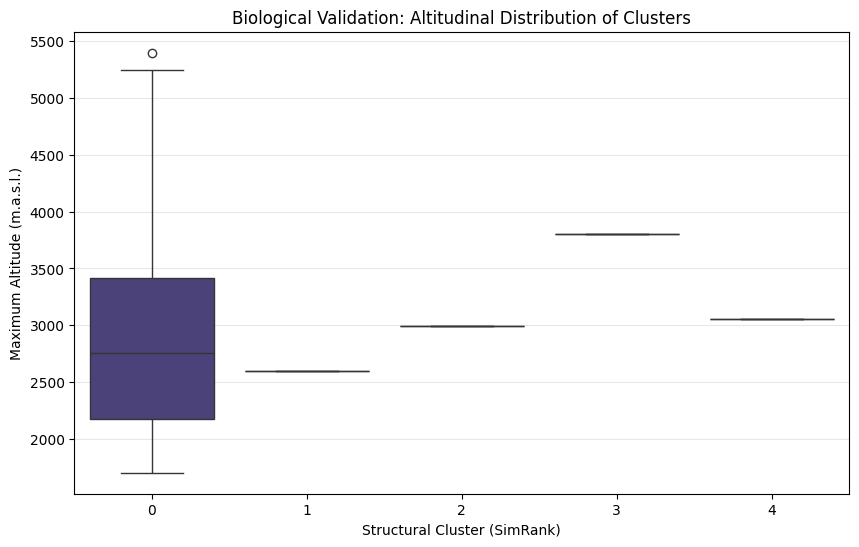


--- ECOLOGICAL CHARACTERIZATION OF CLUSTERS ---


,Average Altitude,Environment,No. Species
SimRank_Cluster,,,
0,2861.288462,tropical,104
1,2600.000000,tropical,1
2,2990.000000,tropical,1
3,3800.000000,sub-alpine temperate,1
4,3050.000000,sub-alpine-tropical,1


In [ ]:
#@title SimRank Validation and Ecological Cluster Characterization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# ==============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ==============================================================================
# 1.1 Load the complete original database (adjust path and name)
# I assume the file is the same as mentioned before
df_original = pd.read_excel("aav0379__scheele_data_s1.xlsx", sheet_name="Declined_species")
df_original['altitud_max'] = df_original['Alt_range'].str.extract(r'-(\d+)', expand=False).astype(float)

# Join the recovered altitude to your current 'anfibios' DataFrame using Species as key
if 'altitud_max' not in anfibios.columns:
    anfibios = anfibios.merge(df_original[['Species', 'altitud_max']], on='Species', how='left')

# ---------------------------------------------------------
# 2. NOW, THE SIMRANK VALIDATION CODE
# ---------------------------------------------------------

# Calculate SimRank Similarity (if not already calculated)
if 'sim_matrix' not in locals():
    print("Calculating SimRank matrix (this might take a while)...")
    sim_matrix_dict = nx.simrank_similarity(G)
    nodes = list(G.nodes())
    sim_matrix = pd.DataFrame([[sim_matrix_dict[u][v] for v in nodes] for u in nodes], index=nodes, columns=nodes)

# Group species (Clustering) - Using 'metric' instead of 'affinity'
cluster_model = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='complete')
clusters = cluster_model.fit_predict(1 - sim_matrix)

df_clusters = pd.DataFrame({'Species': list(G.nodes()), 'SimRank_Cluster': clusters})

# Cross-reference with biological data (Now altitud_max exists)
validacion = df_clusters.merge(anfibios[['Species', 'altitud_max', 'Environment', 'Severity']],
                               left_on='Species', right_on='Species')

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=validacion, x='SimRank_Cluster', y='altitud_max', palette='viridis')
plt.title("Biological Validation: Altitudinal Distribution of Clusters")
plt.xlabel("Structural Cluster (SimRank)")
plt.ylabel("Maximum Altitude (m.a.s.l.)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# --- SUMMARY TABLE ---
print("\n--- ECOLOGICAL CHARACTERIZATION OF CLUSTERS ---")
resumen = validacion.groupby('SimRank_Cluster').agg({
    'altitud_max': 'mean',
    'Environment': lambda x: x.mode()[0] if not x.mode().empty else "Mixed",
    'Species': 'count'
}).rename(columns={'Species': 'No. Species', 'altitud_max': 'Average Altitude'})
display(resumen)

/tmp/ipython-input-379784202.py:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete')


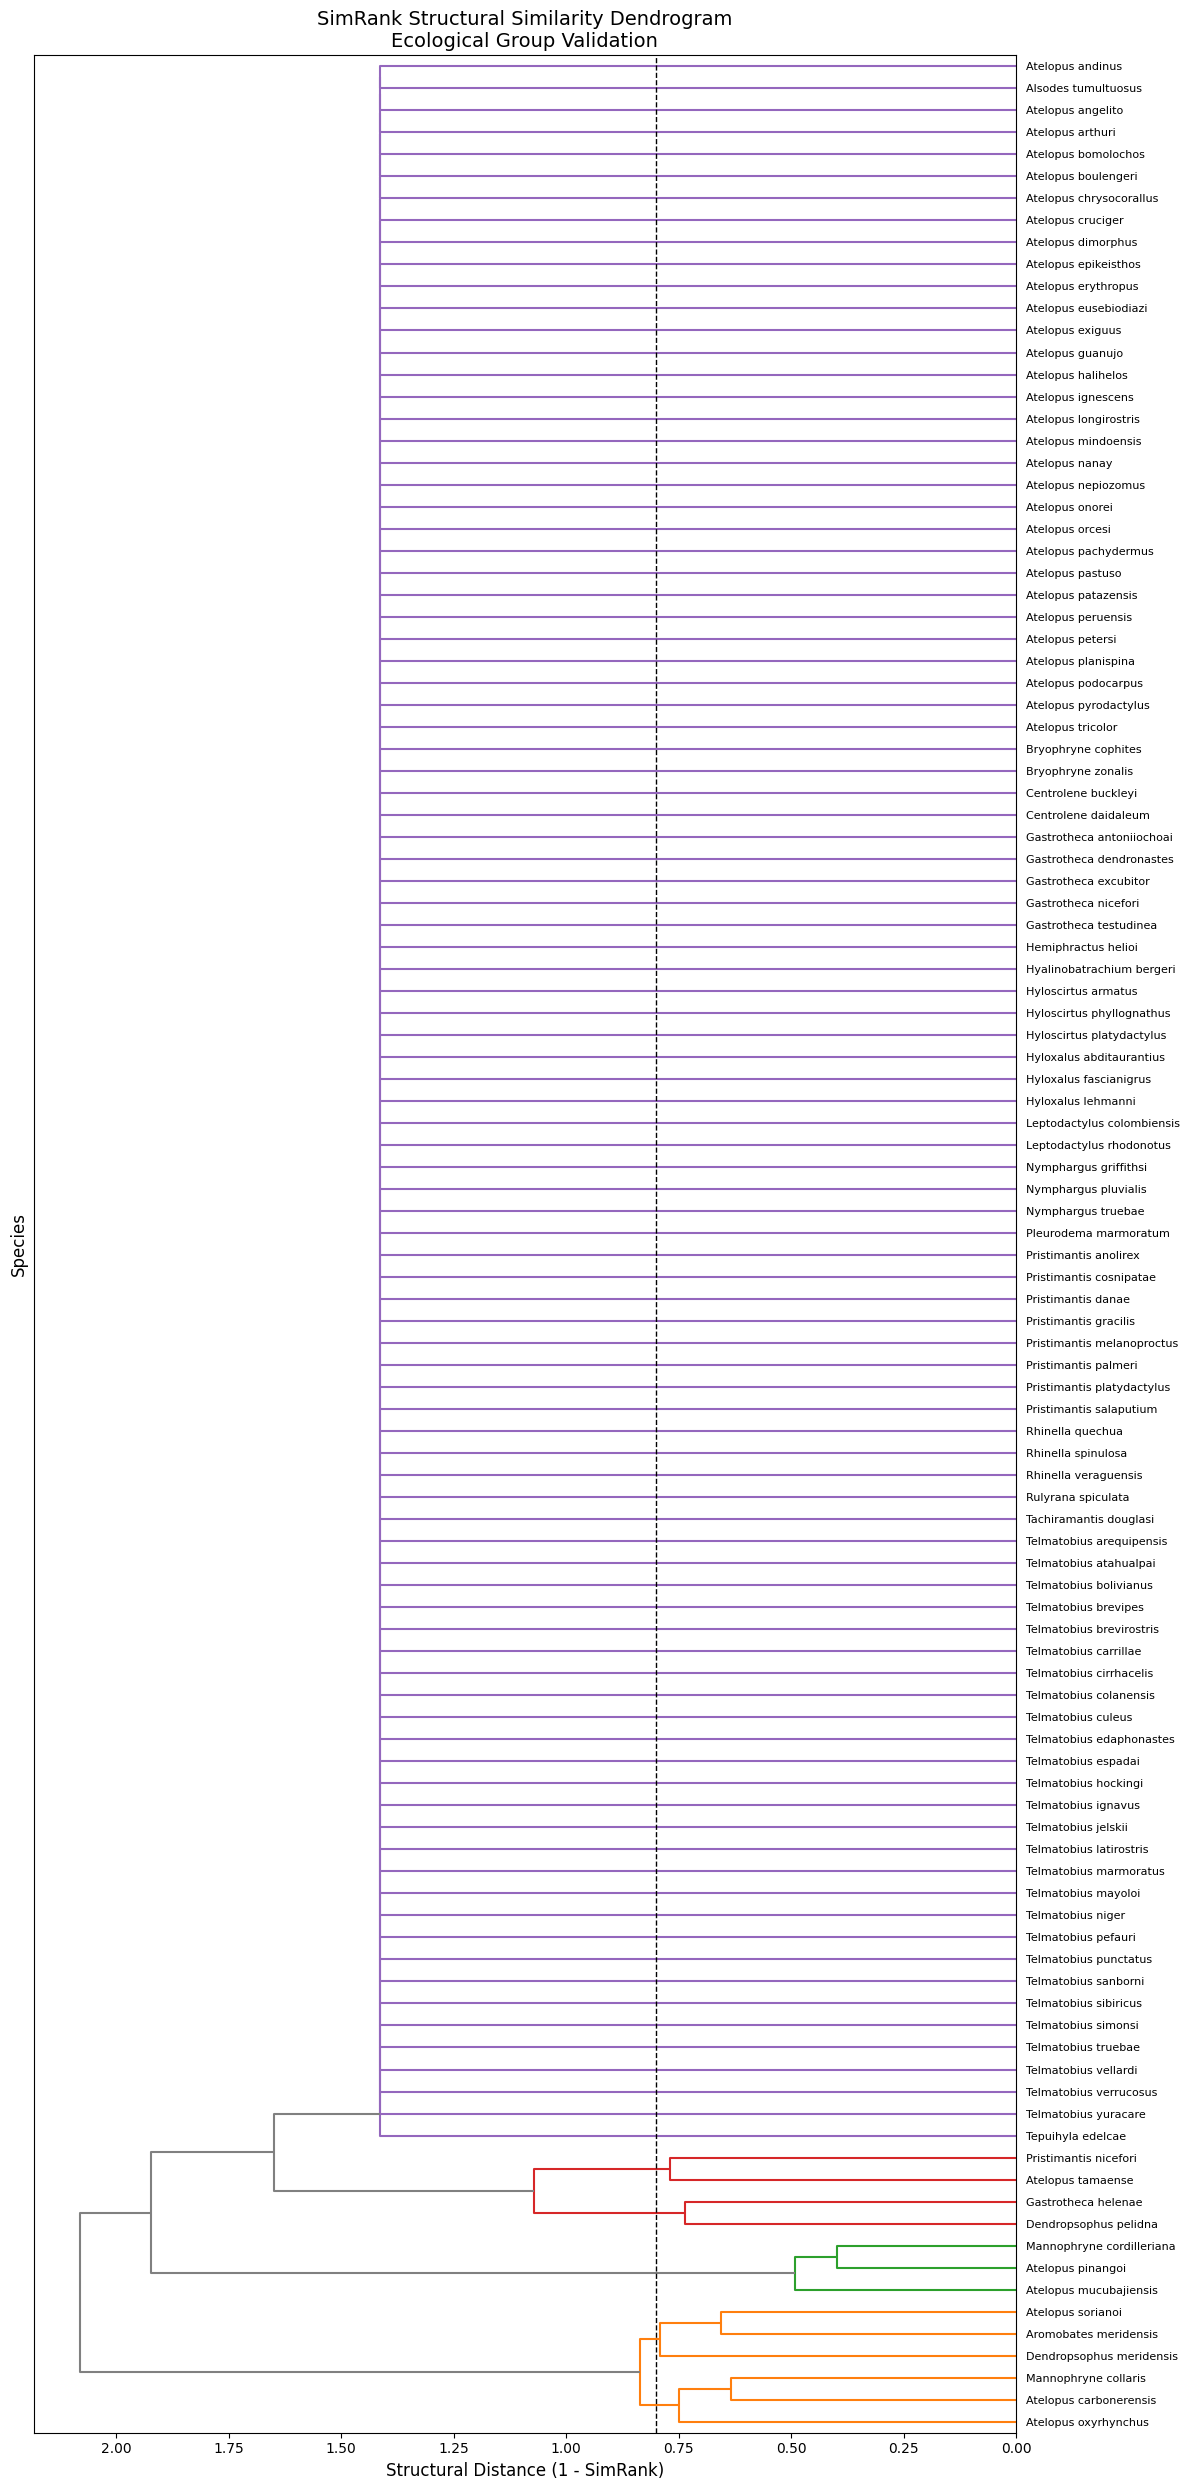

In [ ]:
#@title SimRank Structural Similarity Dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd

# 1. Prepare the Distance Matrix
# In hierarchical clustering, Distance = 1 - Similarity
# We ensure it's purely numeric (no names in indices for the calculation)
dist_matrix = 1 - sim_matrix.values

# 2. Calculate the Linkage (the tree structure)
# We use 'complete' linkage to be consistent with your previous AgglomerativeClustering code
Z = linkage(dist_matrix, method='complete')

# 3. Configure the Plot
plt.figure(figsize=(12, 25)) # Tall and narrow to fit all names

# 4. Draw the Dendrogram
dendro = dendrogram(
    Z,
    labels=sim_matrix.index,  # Species names
    orientation='left',       # Horizontal for better name readability
    leaf_font_size=8,         # Font size
    color_threshold=0.7 * max(Z[:, 2]), # Automatically colors the main clusters
    above_threshold_color='gray'
)

# Visual cut-off line (optional, helps to see where you cut the 5 groups)
# Adjust the value 0.8 depending on where you see the main branches separate best
plt.axvline(x=0.8, c='k', lw=1, linestyle='--')

plt.title('SimRank Structural Similarity Dendrogram\nEcological Group Validation', fontsize=14)
plt.xlabel('Structural Distance (1 - SimRank)', fontsize=12)
plt.ylabel('Species', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
#@title Filter to see who is in Cluster 3 (High Mountain)
outlier = validacion[validacion['SimRank_Cluster'] == 3]

print(f"--- OUTLIER SPECIES (CLUSTER 3) ---")
print(f"Name: {outlier['Species'].values[0]}")
print(f"Altitude: {outlier['altitud_max'].values[0]} masl")
print(f"Environment: {outlier['Environment'].values[0]}")
print(f"Severity: {outlier['Severity'].values[0]}")

--- OUTLIER SPECIES (CLUSTER 3) ---
Name: Telmatobius verrucosus
Altitude: 3800.0 masl
Environment: sub-alpine  temperate
Severity: 4


In [ ]:
#@title Calculate SimRank for g0 and g1
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# --- PREVIOUS STEP: Calculate SimRank for g0 and g1 ---
# Assuming 'sim_matrix' (for G) already exists from your previous code.
# If not, uncomment the following line:
# sim_matrix_dict_G = nx.simrank_similarity(G); nodes_G = list(G.nodes()); sim_matrix = pd.DataFrame([[sim_matrix_dict_G[u][v] for v in nodes_G] for u in nodes_G], index=nodes_G, columns=nodes_G)

print("Calculating SimRank for g0...")
sim_dict_g0 = nx.simrank_similarity(g0)
nodes_g0 = list(g0.nodes())
sim_matrix_g0 = pd.DataFrame([[sim_dict_g0[u][v] for v in nodes_g0] for u in nodes_g0], index=nodes_g0, columns=nodes_g0)

print("Calculating SimRank for g1...")
sim_dict_g1 = nx.simrank_similarity(g1)
nodes_g1 = list(g1.nodes())
sim_matrix_g1 = pd.DataFrame([[sim_dict_g1[u][v] for v in nodes_g1] for u in nodes_g1], index=nodes_g1, columns=nodes_g1)

print("Calculations ready!")

Calculating SimRank for g0...
Calculating SimRank for g1...
Calculations ready!


In [ ]:
#@title Draw Dendrogram on Axis
def dibujar_dendrograma_en_eje(sim_matrix_input, ax, titulo, tamaño_fuente=8):
    """
    Draws a dendrogram based on a SimRank similarity matrix within a specific axis (ax).
    """
    if sim_matrix_input.empty:
         ax.text(0.5, 0.5, "Empty or very small network", ha='center', va='center')
         ax.set_title(titulo)
         return

    # 1. Prepare the Distance Matrix (Your original code)
    dist_matrix = 1 - sim_matrix_input.values

    # 2. Calculate the Linkage
    # We use 'complete' for consistency, but if it gives an error for very small networks
    # you could try method='average' or 'single'.
    try:
        Z = linkage(dist_matrix, method='complete')
    except ValueError:
         ax.text(0.5, 0.5, "Could not calculate linkage\n(too few nodes)", ha='center', va='center')
         ax.set_title(titulo)
         return

    # 3. Draw the Dendrogram on the specific axis (ax=ax)
    dendro = dendrogram(
        Z,
        labels=sim_matrix_input.index,
        orientation='left',
        leaf_font_size=tamaño_fuente, # Adjustable depending on network size
        ax=ax,                      # <--- IMPORTANT! Draws on the subplot
        color_threshold=0.7 * max(Z[:, 2]) if len(Z) > 0 else 0,
        above_threshold_color='gray'
    )

    ax.set_title(titulo, fontsize=12)
    ax.set_xlabel('Structural Distance (1 - SimRank)')
    # We remove the Y label to save space, the names are already there
    # ax.set_ylabel('Species')

Drawing G...
Drawing g0...
Drawing g1...


/tmp/ipython-input-3577901352.py:18: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete')
/tmp/ipython-input-3577901352.py:18: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete')
/tmp/ipython-input-3577901352.py:18: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete')


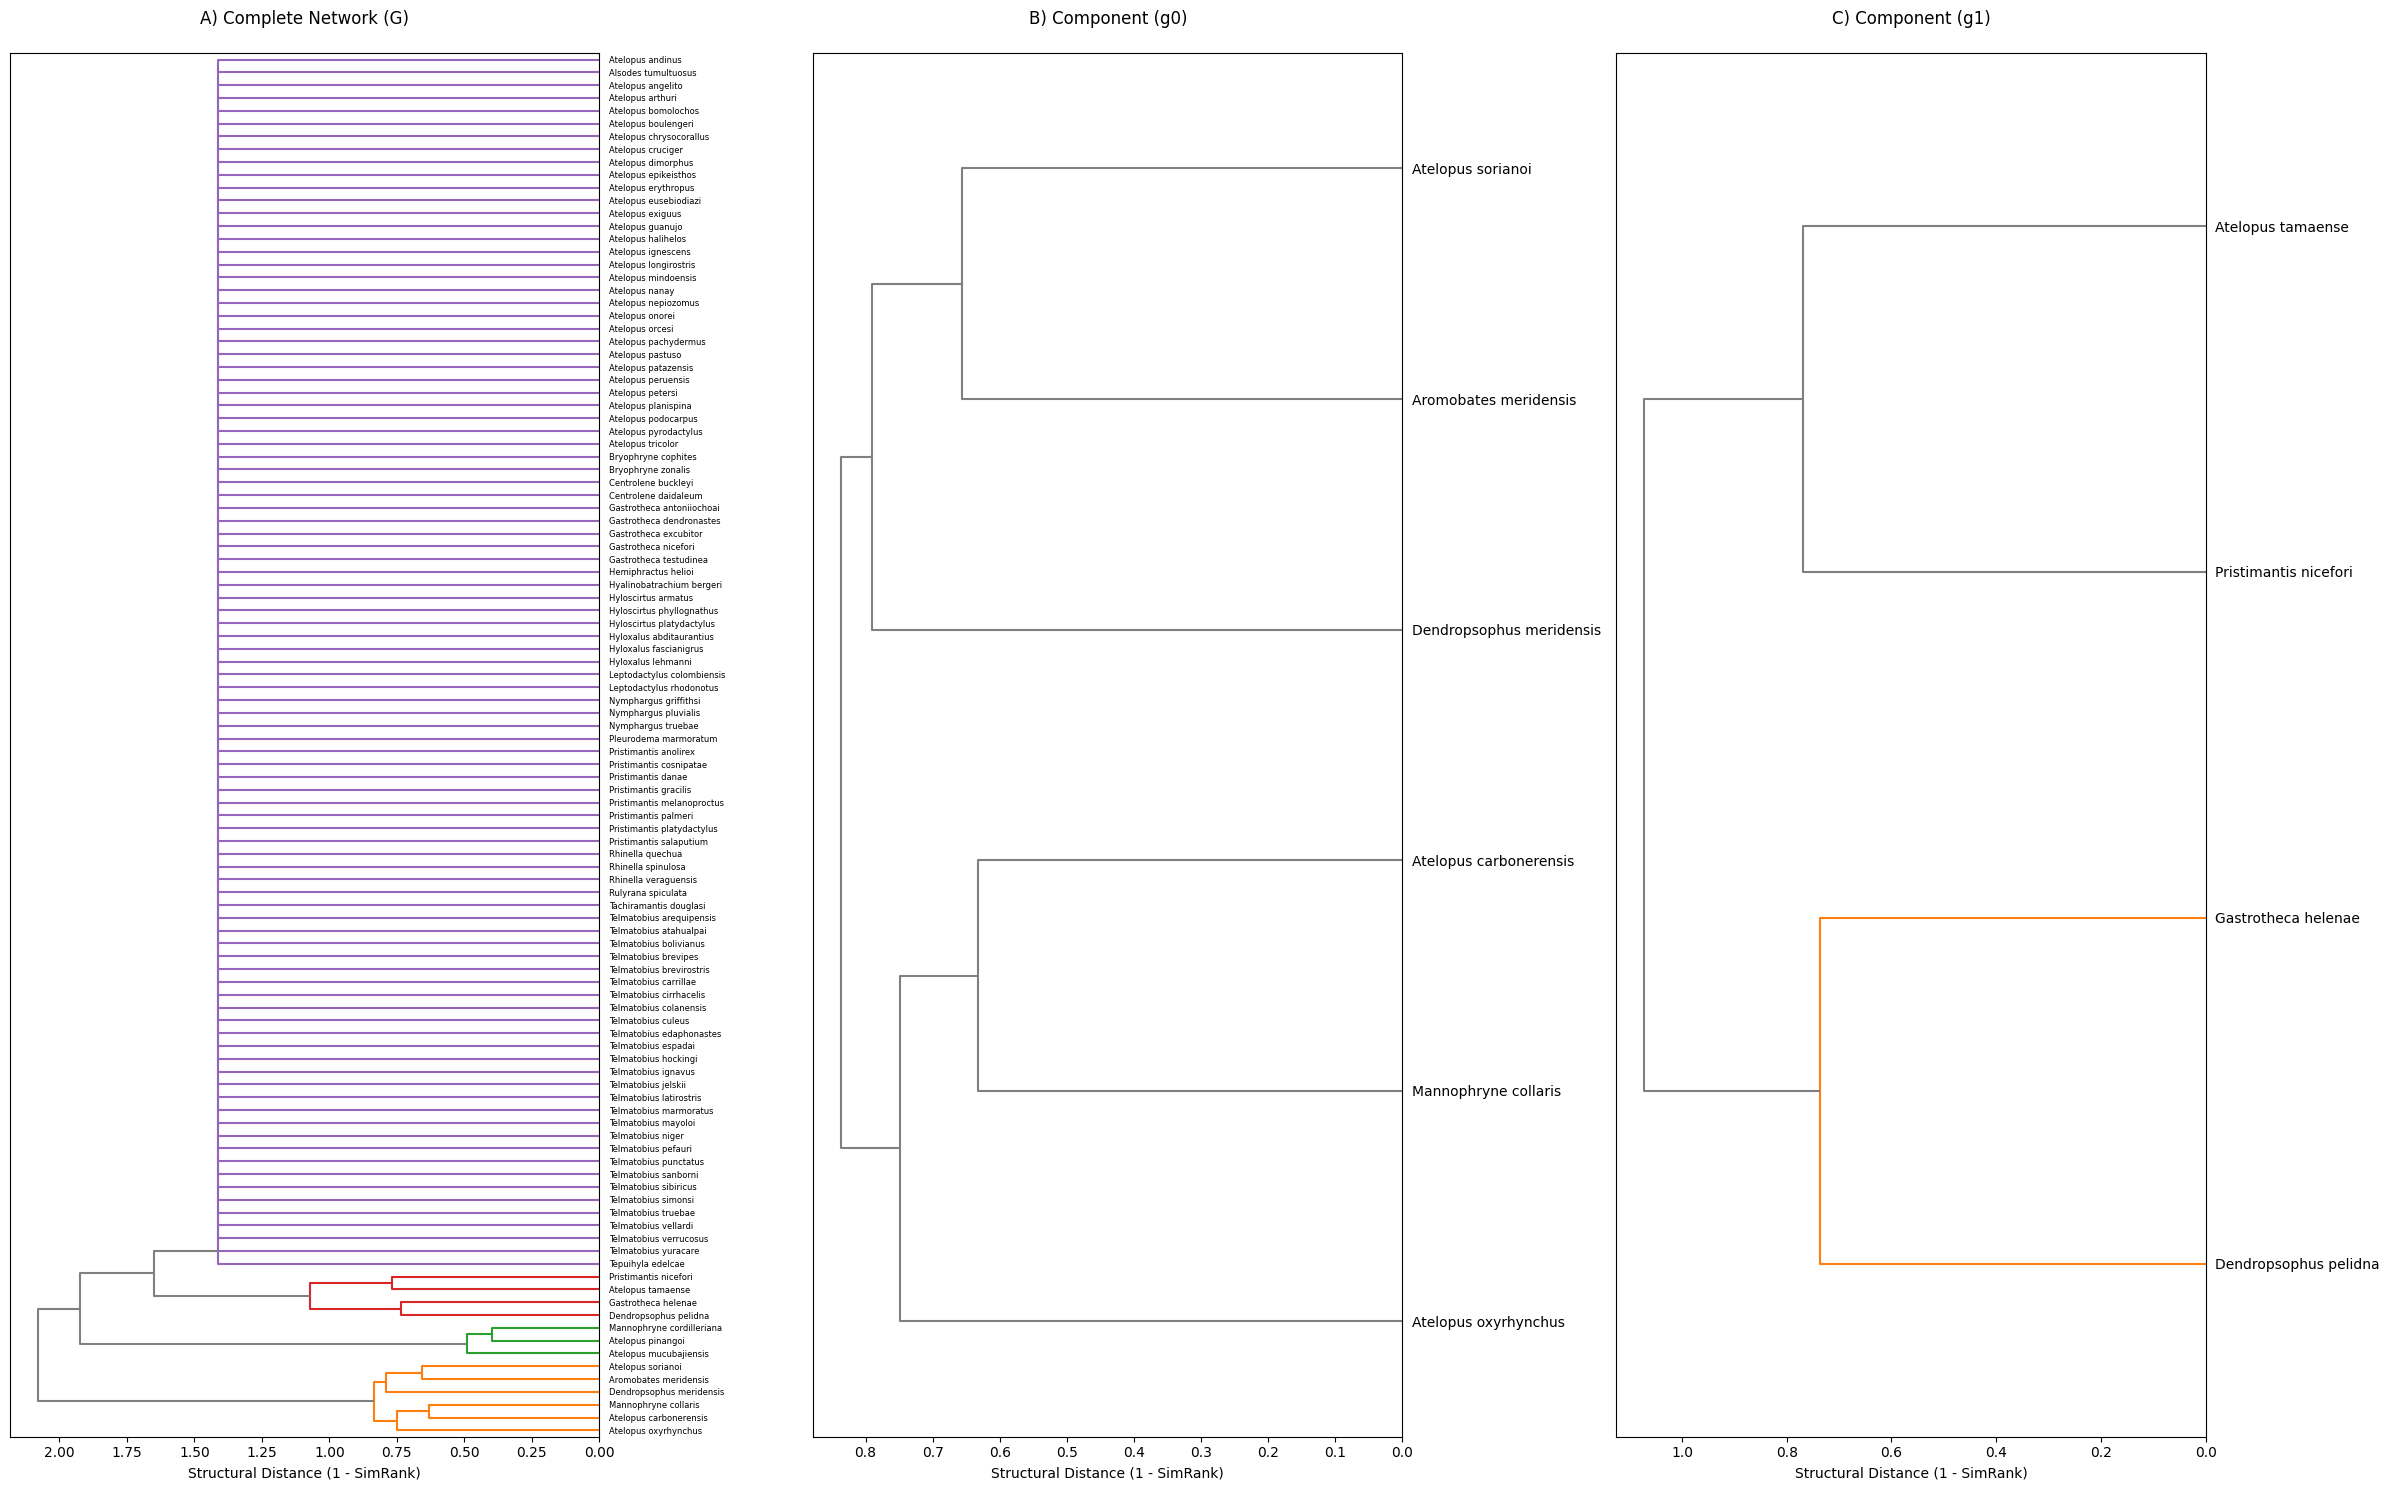

In [ ]:
#@title Dendrogram Visualization for Networks
# Set up the figure with 1 row and 3 columns
# We use a wide figure (figsize=(24, 15)) to ensure the names are readable
fig, axes = plt.subplots(1, 3, figsize=(24, 15))

# --- Panel A: Complete Network (G) ---
# We use a small font size (e.g., 6 or 7) because there are many species
print("Drawing G...")

dibujar_dendrograma_en_eje(

    sim_matrix,      # Original G matrix

    axes[0],         # First subplot

    "A) Complete Network (G)\n",

    tamaño_fuente=6  # Small font to fit 108 names


)

# --- Panel B: Component (g0) ---
# Larger font
print("Drawing g0...")
dibujar_dendrograma_en_eje(
    sim_matrix_g0,   # g0 Matrix
    axes[1],         # Second subplot
    "B) Component (g0)\n",
    tamaño_fuente=10
)

# --- Panel C: Component (g1) ---
print("Drawing g1...")
dibujar_dendrograma_en_eje(
    sim_matrix_g1,   # g1 Matrix
    axes[2],         # Third subplot
    "C) Component (g1)\n",
    tamaño_fuente=10
)

plt.tight_layout()
plt.show()

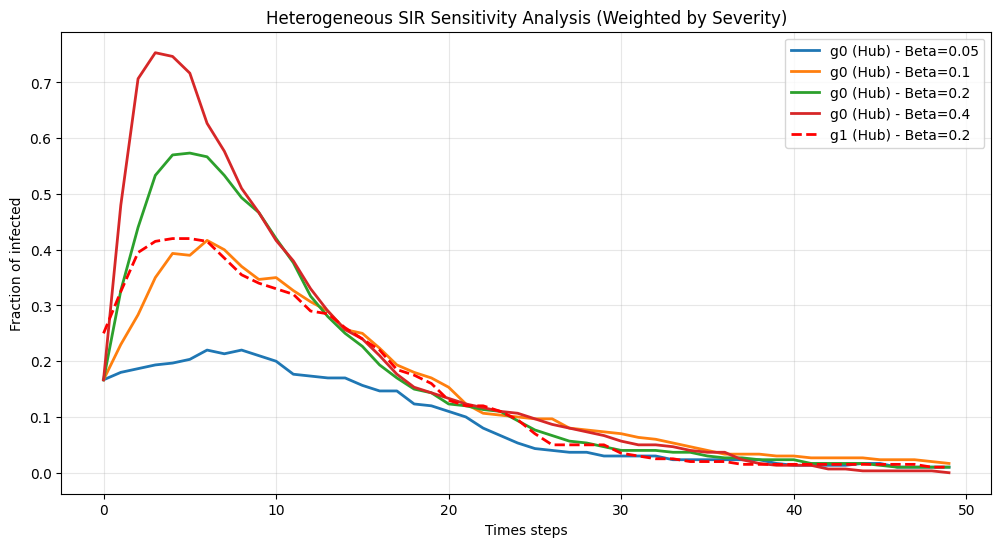

In [ ]:
#@title Heterogeneous SIR Sensitivity Analysis
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- HETEROGENEOUS SIR FUNCTION (Addresses the homogeneity critique) ---
def simulate_heterogeneous_SIR(G, seed_nodes, base_beta, gamma, steps=50, iterations=50):
    """
    Simulates SIR where infection probability depends on the node's SEVERITY.
    real_beta = base_beta * severity_factor
    """
    avg_results = np.zeros(steps)

    for _ in range(iterations):
        # States: 0: Susceptible, 1: Infected, 2: Recovered/Dead
        states = {n: 0 for n in G.nodes()}

        # Initial infection
        current_infected = []
        for n in seed_nodes:
            if n in G.nodes():
                states[n] = 1
                current_infected.append(n)

        infected_history = [len(current_infected) / len(G)]

        for t in range(1, steps):
            new_infected = []
            new_recovered = []

            # Infection Dynamics
            # We iterate through infected nodes to see who they infect
            for u in current_infected:
                neighbors = list(G.neighbors(u))
                for v in neighbors:
                    if states[v] == 0: # If susceptible
                        # CRITIQUE ADDRESSED: Beta depends on the Severity of node V
                        # We assume the network has a 'Severity' attribute (1 to 4)
                        sev_v = G.nodes[v].get('Severity', 2) # Default value 2

                        # Risk factor: Severity 4 doubles the risk, Severity 1 lowers it
                        # Normalization: (sev / 4) or adjusted
                        infection_prob = base_beta * (sev_v / 2.5)

                        if np.random.random() < infection_prob:
                            new_infected.append(v)

            # Recovery/Death Dynamics
            for u in current_infected:
                if np.random.random() < gamma:
                    new_recovered.append(u)

            # Update states (synchronous)
            for v in new_infected:
                states[v] = 1
            for u in new_recovered:
                states[u] = 2

            # Update list of active infected nodes
            current_infected = [n for n, s in states.items() if s == 1]
            infected_history.append(len(current_infected) / len(G))

        avg_results += np.array(infected_history)

    return avg_results / iterations

# --- NETWORK PREPARATION (Example with g0) ---
# Ensure you assign severity to nodes before running
# Example: nx.set_node_attributes(g0, severity_dictionary, 'Severity')
# If you don't have the dictionary at hand, the code assumes medium severity (2)

# Sensitivity Analysis Parameters (Response to reviewers)
betas = [0.05, 0.1, 0.2, 0.4] # Beta sweep
gamma = 0.1 # Slow recovery (typical of Bd, the fungus persists)

plt.figure(figsize=(12, 6))

# --- SCENARIO 1: Component g0 (Infection at the HUB) ---
hub_g0 = 'Atelopus carbonerensis' # The most central node found earlier
if hub_g0 in g0.nodes():
    for b in betas:
        curve = simulate_heterogeneous_SIR(g0, [hub_g0], base_beta=b, gamma=gamma)
        plt.plot(curve, label=f'g0 (Hub) - Beta={b}', linestyle='-', linewidth=2)

# --- SCENARIO 2: Component g1 (Infection at the HUB) ---
hub_g1 = 'Dendropsophus pelidna' # The critical node of g1
if hub_g1 in g1.nodes():
    # We only plot an intermediate beta for comparison
    curve_g1 = simulate_heterogeneous_SIR(g1, [hub_g1], base_beta=0.2, gamma=gamma)
    plt.plot(curve_g1, label=f'g1 (Hub) - Beta=0.2', linestyle='--', color='red', linewidth=2)

plt.title("Heterogeneous SIR Sensitivity Analysis (Weighted by Severity)")
plt.xlabel("Times steps")
plt.ylabel("Fraction of infected")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Variables selected for PCA: ['Bio01', 'Bio02', 'Bio03', 'Bio04', 'Bio05', 'Bio06', 'Bio07', 'Bio08', 'Bio09', 'Bio10', 'Bio11', 'Bio12', 'Bio13', 'Bio14', 'Bio15', 'Bio16', 'Bio17', 'Bio18', 'Bio19']


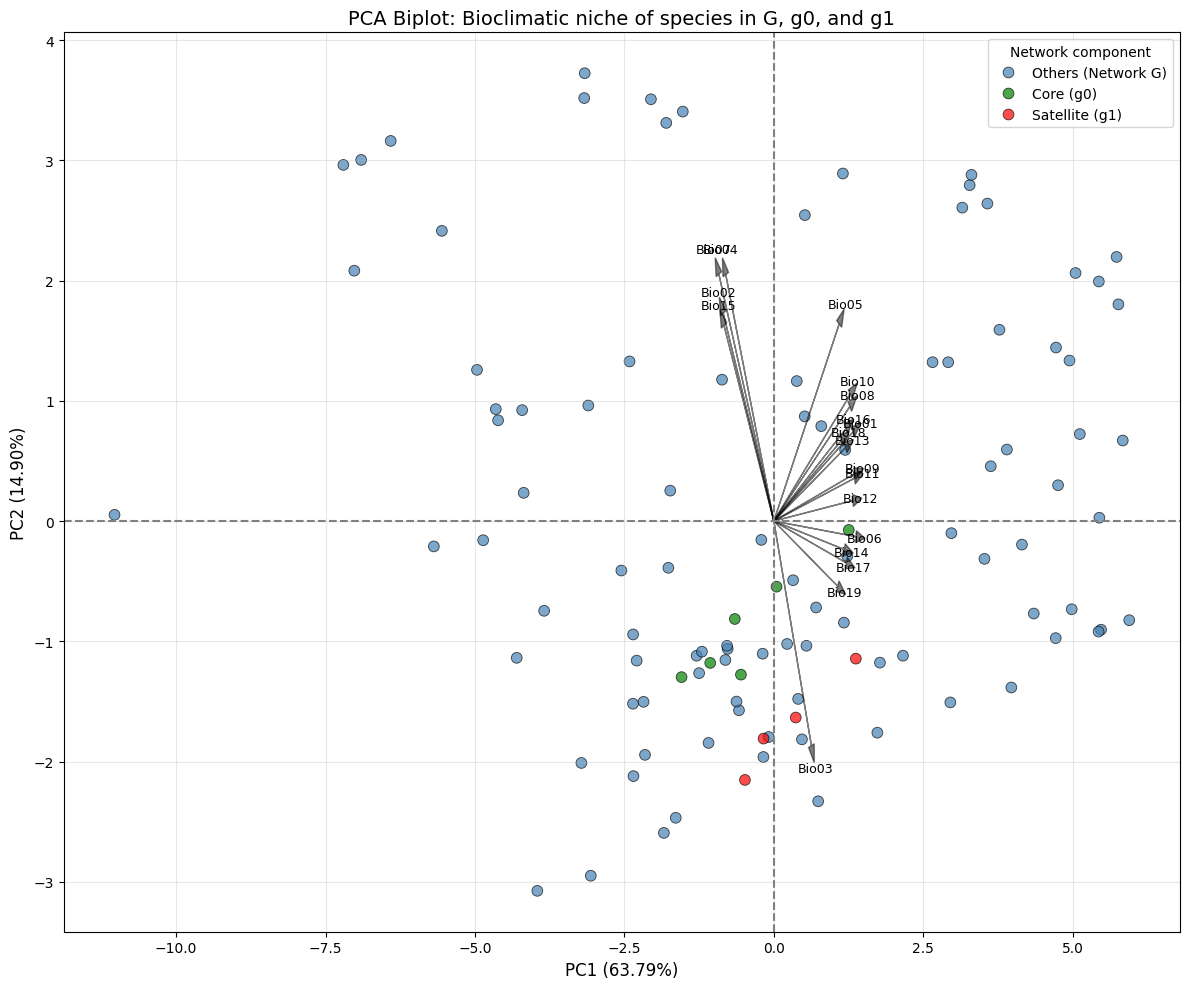

In [ ]:
#@title PCA Biplot: Bioclimatic Niche of Species
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ==============================================================================
# 1.1 Load the complete original database (adjust path and name)
# Assuming the file is the same as mentioned before
df_original = pd.read_excel("aav0379__scheele_data_s1.xlsx", sheet_name="Declined_species")

# 1.2 Get the lists of species from your networks (assuming G, g0, g1 exist)
especies_G = list(G.nodes())
nodes_g0 = set(g0.nodes())
nodes_g1 = set(g1.nodes())

# 1.3 Filter the original dataframe to keep ONLY the species in G
df_pca = df_original[df_original['Species'].isin(especies_G)].copy()

# 1.4 Create a grouping column for coloring (g0, g1, or Other G)
def asignar_grupo(especie):
    if especie in nodes_g0:
        return 'Core (g0)'
    elif especie in nodes_g1:
        return 'Satellite (g1)'
    else:
        return 'Others (Network G)'

df_pca['Grupo_Red'] = df_pca['Species'].apply(asignar_grupo)

# ==============================================================================
# STEP 2: SELECT AND STANDARDIZE BIOCLIMATIC VARIABLES
# ==============================================================================
# 2.1 Select Bio01 to Bio19 columns (numerical environmental variables)
cols_bio = [col for col in df_original.columns if col.startswith('Bio') and col[3:].isdigit()]
print(f"Variables selected for PCA: {cols_bio}")

X = df_pca[cols_bio]

# IMPORTANT: Remove rows with NaNs if there are any in these columns
X = X.dropna()
# Synchronize the metadata dataframe (Species, Grupo_Red) with the remaining rows
df_pca = df_pca.loc[X.index]

# 2.2 Standardize the data (Z-score: mean=0, std=1)
# Essential because temperature (Bio01) and precipitation (Bio12) have very different scales.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ==============================================================================
# STEP 3: EXECUTE PCA
# ==============================================================================
# Calculate the first 2 principal components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
# Add group and species information
pca_df['Grupo_Red'] = df_pca['Grupo_Red'].values
pca_df['Species'] = df_pca['Species'].values

# Get explained variance
var_explicada = pca.explained_variance_ratio_ * 100

# ==============================================================================
# STEP 4: GENERATE THE BIPLOT (CUSTOM GRAPH)
# ==============================================================================
plt.figure(figsize=(12, 10))

# 4.1 Draw the points (species scatter plot)
# Using a color palette similar to your previous dendrograms
colores = {'Core (g0)': 'green', 'Satellite (g1)': 'red', 'Others (Network G)': 'steelblue'}
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Grupo_Red',
    palette=colores,
    data=pca_df,
    s=60, alpha=0.7, edgecolor='k'
)

# 4.2 Draw the vectors (arrows) of the original variables
# The "loadings" tell us how much each variable contributes to PC1 and PC2
loadings = pca.components_.T
scale_factor = 5 # Factor to lengthen the arrows for better visibility

for i, feature_name in enumerate(cols_bio):
    # Vector coordinates
    x_vec = loadings[i, 0] * scale_factor
    y_vec = loadings[i, 1] * scale_factor

    # Draw the arrow
    plt.arrow(0, 0, x_vec, y_vec, color='k', alpha=0.5, head_width=0.1, linewidth=1)
    # Place the text (BioXX variable name) at the end of the arrow
    plt.text(x_vec * 1.1, y_vec * 1.1, feature_name, color='k', ha='center', va='center', fontsize=9)

# 4.3 Final chart configuration

plt.xlabel(f'PC1 ({var_explicada[0]:.2f}%)', fontsize=12)

plt.ylabel(f'PC2 ({var_explicada[1]:.2f}%)', fontsize=12)

plt.title('PCA Biplot: Bioclimatic niche of species in G, g0, and g1', fontsize=14)

plt.axhline(0, color='grey', linestyle='--')

plt.axvline(0, color='grey', linestyle='--')

plt.grid(True, alpha=0.3)

plt.legend(title='Network component')


plt.tight_layout()

plt.show()